In [1]:
import sympy as sy
sy.init_printing(use_latex=True)
import numpy as np
import pandas as pd
import scipy as sc
import scipy.linalg as LA
import matplotlib.pyplot as plt
import math
import vpython as vp
vec = vp.vector

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. Abgabe aus dem Fach Modellbildung und Simulation - Klassische Mechanik 2

## Keplerproblem

Zwei Massen $M$ und $m$, die den Abstand $r$ zueinander besitzen, ziehen sich gegenseitig mit der Kraft
$$ \vec{F}_G = -G\frac{Mm}{r^2}\vec{e}_r $$
an. $G$ ist die universelle Gravitationskonstante.

In [2]:
x = sy.symbols('x')

### 1.
Im File Sat.txt sind die Umlaufzeiten $T$ und mittleren Radien $r$ der Umlaufbahnen von vier Satelliten angegeben (die einen Asteroiden umkreisen). Zeigen Sie, dass sich die Datein mit der Form $T=Cr^n$ beschreiben lassen. Bestimmen Sie $n$ und $C$, indem sie Sie die Daten logarithmisch auftragen. Schätzen Sie den fehlenden Radius ab.

Aufgabe herausfinden was C und n sein können.

Die Umlaufzeit ist gegeben durch $a= \omega^2r = (\frac{2\pi}{T})^2r$

['T in a ', 'r in Gm ']
[['T in a ', 'r in Gm '], ['0.44', '0.088'], ['1.61', '0.208'], ['3.88', '0.374'], ['6.20', '?'], ['7.89', '0.600']]
{'T in a ': [0.44, 1.61, 3.88, 6.2, 7.89], 'r in Gm ': [0.088, 0.208, 0.374, x, 0.6]}
[0.44, 1.61, 3.88, 7.89]
[0.088, 0.208, 0.374, 0.6]


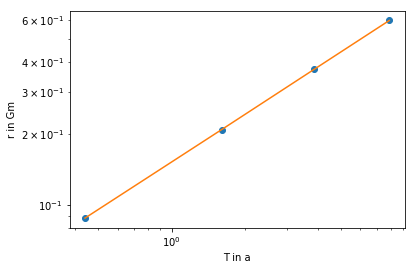

In [27]:
with open("Sat.txt", "r") as f:
    sat = [line.split() for line in f]
header_ = sat[0]
header = []
h_str1 = ''
h_str2 = ''
for i in range(0, 3):
    h_str1 += header_[i] + ' '
    h_str2 += header_[i+3] + ' '
header = [h_str1, h_str2]
sat[0] = header
print(header)
print(sat)
sat_data = {}
for s in range(1, len(sat)):
    for n in range(0, len(sat[s])):
        if sat[s][n] == '?':
            sat[s][n] = x
        else:
            sat[s][n] = float(sat[s][n])
sat_data = {sat[0][i]: [ line[i] for line in sat[1:] ]  for i in range(len(sat[0]))}
print(sat_data)
xs = sat_data['T in a '][0:3]
xs.append(sat_data['T in a '][4])
print(xs)

ys = sat_data['r in Gm '][0:3]
ys.append(sat_data['r in Gm '][4])
print(ys)
plt.loglog(xs, ys, 'o')
plt.loglog(xs, ys)
plt.xlabel('T in a')
plt.ylabel('r in Gm')
plt.show()

$\mathrm{ln}(a) + b \mathrm{ln}(x) = \mathrm{ln}(y) $
Berechnung Potenzfunktion : $y = ax^b$

### 2.
Schreiben Sie ein Programm, das die Differentialgleichung
$$ m\ddot{\vec{r}} = -G\frac{Mm}{r^3}\vec{r} $$
löst und visualisieren Sie die Bahnkurve der Erde um die Sonne. Verwenden sie als Anfangsgeschwindigkeit $(0.0, 29.8)*10^3m/s$ und den Anfangsort der Erde $(1.4960, 0.0)*10^{11}m$ (Die Sonne ruhe anfänglich im Urspung). Überprüfen Sie die Impuls-, Drehimpuls- und Energieerhaltung numerisch.

In [4]:
M, m, r, G, vr, t = sy.symbols('M, m, r, G, \\vec{r}, t')
ddr = sy.symbols('\ddot{\\vec{r}}', function=True)

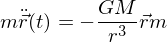

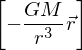

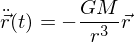

In [5]:
gl = sy.Eq(m*ddr(t), -G*((M*m)/r**3)*vr)
display(gl)
gl = sy.solve(gl, ddr(t))
display(gl)
gl2 = sy.Eq(ddr(t), gl[0])
display(gl2)

In [6]:
r1 = sy.symbols('\\vec{r}_1')
rx1 = sy.symbols('r_{x_1}')
ry1 = sy.symbols('r_{y_1}')
m_erde = 5.974e24
m_sonne = 1.9891e30
a_ort_e = np.array([1.4960e11, 0.])
a_ort_sonne = np.array([0., 0.])
a_gesch_e = np.array([0., 29.8e3])

In [7]:
def rk4(y_n, h, f):
    k1 = f
    k2 = np.array(ode(t+(h/2), y+ (h/2)*k1))
    k3 = np.array(ode(t+(h/2), y+(h/2)*k2))
    k4 = np.array(ode(t+h, y+h*k3))
    ynew = y + h*(k1+2*k2+2*k3+k4)/6
    return np.array(y_n+h*f)

In [8]:
#Grafik
def Bahnkurve_Plot(anfangsort, anfangsgesch, t0, tend, N=1000):
    vr_val = anfangsort-a_ort_sonne
    print('abstand', vr_val)
    r_val = LA.norm(vr_val)
    print('abstand norm ', r_val)
    M_val = m_sonne
    G_val = 6.67408E-11
    ddr_t = (-(G_val*M_val*np.array([rx1, ry1]))/(sy.sqrt(rx1**2+ry1**2)**3))
    ddr_n = (-(G_val*M_val*vr_val)/(r_val**3))
    display(ddr_t)
    dr_n = anfangsgesch
    r_n = anfangsort
    xs = [r_n[0]]
    ys = [r_n[1]]
    tvals, h = np.linspace(t0, tend, N, retstep=True)
    plt.plot(anfangsort[0], anfangsort[1], 'ob', label='Anfangsort Erde', ms=4)
    plt.plot(a_ort_sonne[0], a_ort_sonne[1], 'oy', label='Anfangsort Sonne', ms=10)
    for ts in tvals:
        ddr_np1 = np.array([0., 0.])
        #print('ddr_t', ddr_t[1].subs(rx1, r_n[0]).subs(ry1, r_n[1]))
        #print('dr_n', dr_n)
        #print('r_n', r_n)
        ddr_np1[0] = ddr_t[0].subs(rx1, r_n[0]).subs(ry1, r_n[1])
        ddr_np1[1] = ddr_t[1].subs(rx1, r_n[0]).subs(ry1, r_n[1])
        #display(ddr_np1)
        dr_np1 = euler(dr_n, h, ddr_np1)
        r_np1 = euler(r_n, h, dr_np1)
        #print('r_np1', r_np1)
        
        xs.append(r_np1[0])
        ys.append(r_np1[1])
        
        ddr_n = ddr_np1
        dr_n = dr_np1
        r_n = r_np1
    #print(xs)
    #print(ys)
    plt.plot(xs, ys, 'b', label='Bahnkurve Erde')
    plt.plot(xs[-1], ys[-1], 'ob', label='Endort Erde', mec='#000000')
    plt.legend()
    plt.axis([-1.7e11, 2.5e11, -1.7e11, 2.5e11])
    plt.show()

abstand [1.496e+11 0.000e+00]
abstand norm  149600000000.0


array([-1.3275412528e+20*r_{x_1}/(r_{x_1}**2 + r_{y_1}**2)**(3/2),
       -1.3275412528e+20*r_{y_1}/(r_{x_1}**2 + r_{y_1}**2)**(3/2)],
      dtype=object)

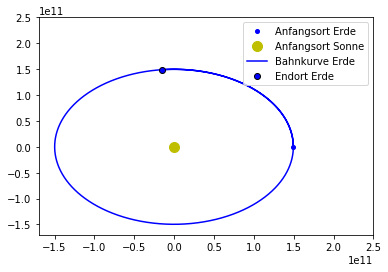

In [9]:
Bahnkurve_Plot(a_ort_e, a_gesch_e, 0, 4e6, N=100000)

In [10]:
def Bahnkurve_Animation(Anfangsort, Anfangsgesch):
    r = np.array(Anfangsort)
    v = np.array(Anfangsgesch)
    
    scene = vp.canvas(title='Bahnkurve Erde', background=vp.color.black, forward=vec(0, 2, -1))
    erde = vp.sphere(pos=vec(r[0], r[1], 0), radius=1e10,color=vp.color.blue)
    sun = vp.sphere(pos=(vec(0, 0, 0)), radius=2e10, color=vp.color.yellow)
    sunlight = vp.local_light(pos=vec(0, 0, 0), color=vp.color.yellow)
    i = 0
    while i <= 100:
        vp.rate(200)
        i += 1

In [11]:
Bahnkurve_Animation(a_ort_e, a_gesch_e)

<IPython.core.display.Javascript object>

### 3.
Überprüfen Sie die Impuls-, Drehimpuls- und Energieerhaltung analytisch. Verwenden Sie dazu Polarkoordinaten und leinten Sie die Bewegungsgleichung in Polarkoordinaten her:
$$ m(\ddot{r} - r*\dot{\theta}^2) = -G\frac{mM}{r^2}$$
$$ m(r\ddot{\theta}+2\dot{r}\dot{\theta}) = 0 $$

### 4.
Varieeren Sie die Anfangsgeschwindigkeit der Erde und beschreiben Sie die verschiedenen Bahnformen, die sich ergeben.

### 5.
Beschrieben Sie mit Hilfe des Programms die Bewegung zweier Fast gleich großer Massen (Zweikörperproblem). Denken Sie an die Impulserhaltung!

### 6.
Drei Sterne seinen anfangs in Ruhe mit folgenden Massen und Positionen (arbitrary units):

|       | Masse |  x |  y |
|:-------:|:-------:|:----:|:----:|
|**Stern 1**|  150  |  3 |  1 |
|**Stern 2**|  200  | -1 | -2 |
|**Stern 3**|  250  | -1 |  1 |

(Die drei Sterne seien in der $xy$-Ebene.)

#### (a)
Zeigen Sie, dass die Bewegungsgleichung für Position $\vec{r}_r$ des ersten Sterns gegeben ist durch:
$$\ddot{\vec{r}}_1 = Gm_2\frac{\vec{r}_2-\vec{r}_1}{|\vec{r}_2-\vec{r}_1|^3} + Gm_3\frac{\vec{r}_3-\vec{r}_1}{|\vec{r}_3-\vec{r}_1|^3} $$
und stellen Sie die Gleichung für $\vec{r}_2$ und $\vec{r}_3$ der beiden anderen Sterne auf.

#### (b)
Setzten Sie $G=1$ und schreiben sie ein Programm, das die Bewegungsgleichungen löst. Plotten Sie $y$ als Funktion von $x$ und animieren Sie die Bewegung. Die Sterne bewegen sich sehr schnell, wenn sie sich nähern und sind sehr langsam, wenn sie weit voneinander entfernt sind. Eine adaptive Methode könnte deshab nützlich sein.